# Восстановление золота из руды

Нам необходимо подготовить прототип модели машинного обучения для ООО «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Будем использовать данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

В ходе выполнения проекта нам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

# Описание данных
# Технологический процесс
* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, * Sulphate, Depressant
* Xanthate **— ксантогенат (промотер, или активатор флотации);
* Sulphate — сульфат (на данном производстве сульфид натрия);
* Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

# Параметры этапов
* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

# Наименование признаков

Наименование имеет следующий формат:
[этап].[тип_параметра].[название_параметра]
 
 Пример: rougher.input.feed_ag


Возможные значения для блока [этап]:
* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики

Возможные значения для блока [тип_параметра]:
* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики

# Расчёт эффективности

Эффективность обогащения рассчитывается по формуле:
$$ Recovery = \frac{C * (F - T)}{F * (C - T)} $$
где:
* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

# Метрика качества

Для решения задачи введём новую метрику качества — `sMAPE` (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Метрика симметричная, т.к. она одинаково учитывает масштаб и целевого признака, и предсказания.

Метрика sMAPE вычисляется так:

$$ sMAPE = \frac{1}{N}\displaystyle\sum_{i=1}^{N}\frac{|y_i-\bar{y_i}|}{|y_i|-|\bar{y_i|}/2} $$



Обозначения:


* $$yi$$ Значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество.
* $$\bar{y_i}$$
Значение предсказания для объекта с порядковым номером i, например, в тестовой выборке.
* $$N$$
Количество объектов в выборке.
* $$\displaystyle\sum_{i=1}^{N}$$
Суммирование по всем объектам выборки (i меняется от 1 до N).

Нужно спрогнозировать сразу две величины:
* эффективность обогащения чернового концентрата rougher.output.recovery;
* эффективность обогащения финального концентрата final.output.recovery.

Итоговая метрика складывается из двух величин:
##        Итоговое  sMAPE = 25% * sMAPE(rougher)+75%*sMAPE(final)

## Подготовка данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 12345
pth0 = '/datasets/gold_recovery_train_new.csv'
pth0_1 = '/content/8_gold_recovery_train_new.csv'
pth1 = '/datasets/gold_recovery_test_new.csv'
pth1_1 = '/content/8_gold_recovery_test_new.csv'
pth2 = '/datasets/gold_recovery_full_new.csv'
pth2_1 = '/content/8_gold_recovery_full_new.csv'
try:
    df_train = pd.read_csv(pth0)
    df_test = pd.read_csv(pth1)
    df_full = pd.read_csv(pth2)
except:
    df_train = pd.read_csv(pth0_1)
    df_test = pd.read_csv(pth1_1)
    df_full = pd.read_csv(pth2_1)

Посмотрим на общую информацию о данных по трем представленным выборкам.

In [ ]:
df_train.info() #посмотрим общую информацию по обучающей выборке

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


Таблица содержит внушительный объем данных - более 14000 строк и 87 столбцов.

In [ ]:
df_test.info() #посмотрим общую информацию по тестовой выборке

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [ ]:
df_full.info() #посмотрим общую информацию по полной выборке

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


Данные в столбцах `date`приведем к формату даты.

In [ ]:
df_train['date']=pd.to_datetime(df_train['date'])
df_test['date']=pd.to_datetime(df_test['date'])
df_full['date']=pd.to_datetime(df_full['date'])

In [ ]:
df_train.head() #посмотрим как выглядят данные в обучающей выборке

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [ ]:
df_test.head() #посмотрим как выглядят данные в тестовой выборке

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [ ]:
df_full.head() #посмотрим как выглядят данные в полной выборке

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Стоит отметить, что признаким в выборках отличаются по масштабу. Это нужно будет учесть при подготовке модели к обучению.

Как обычно, проверим есть ли явные дубликаты.

In [ ]:
df_train.duplicated().sum()

0

Явных дубликатов не оказалось.

Проверим правильно ли рассчитана эффективность обогащения. Для этого вычислим её на обучающей выборке для признака rougher.output.recovery и найдем MAE между нашими расчётами и значением признака. 

In [ ]:
def apply_recovery(row):
    (raw_au,
     output_au,
     output_tail) = (row["rougher.input.feed_au"],
                     row["rougher.output.concentrate_au"],
                     row["rougher.output.tail_au"])
    recovery_metric = (((output_au) * ((raw_au) - (output_tail)))/
                       (((raw_au) * ((output_au) - (output_tail))))) * 100
    return recovery_metric

In [ ]:
test = df_train.dropna(
    subset = ['rougher.input.feed_au',
              'rougher.output.concentrate_au',
              'rougher.output.tail_au'],axis=0).apply(apply_recovery,axis=1)

In [ ]:
mean_absolute_error(df_train.dropna(subset = ["rougher.input.feed_au",
                                    "rougher.output.concentrate_au",
                                    "rougher.output.tail_au",
                                    "rougher.output.recovery"])["rougher.output.recovery"],
                       test)

9.73512347450521e-15

Ошибка ничтожно мала, данные эффективности обогащения в обучающей выборке подсчитаны верно.

Проверим какие колонки отсутствуют в тестовой выборке.

In [ ]:
train_only = []
for col in list(df_train.columns):
    if col not in list(df_test.columns):
        print (col)
        train_only.append(col)
train_only=list(train_only) #список колонок, отсутствующих в тестовой выборке
train_only.remove('final.output.recovery') #удалим из списка колонок, отсутствующих в тестовой выборке, целевые признаки
train_only.remove('rougher.output.recovery')#полученный список признаков будем использовать для обучения моделей

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
final.output.recovery
final.output.tail_ag
final.output.tail_pb
final.output.tail_sol
final.output.tail_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
primary_cleaner.output.tail_au
rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.au_pb_ratio
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_pb
rougher.output.tail_sol
rougher.output.tail_au
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_pb
secondary_cleaner.

In [ ]:
train_only #полученный список признаков будем использовать для обучения моделей

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.output.tail_au',
 'secondary_cleane

Как видно из списка столбцов, из тестовой выборки исключены данные, получаемые на выходе после проведения обогащения (output), а также рассчетные данные (calculation).

Проверим как много пропущенных данных в процентном отношении содержит каждый столбец датафрейма.

In [ ]:
df_train.isnull().sum()/len(df_train)*100


date                                          0.000000
final.output.concentrate_ag                   0.007068
final.output.concentrate_pb                   0.007068
final.output.concentrate_sol                  1.491271
final.output.concentrate_au                   0.000000
                                                ...   
secondary_cleaner.state.floatbank5_a_level    0.007068
secondary_cleaner.state.floatbank5_b_air      0.007068
secondary_cleaner.state.floatbank5_b_level    0.007068
secondary_cleaner.state.floatbank6_a_air      0.014135
secondary_cleaner.state.floatbank6_a_level    0.007068
Length: 87, dtype: float64

Как видно, в данных довольно много пропущенных значений, удалить их просто так нельзя. Попробуем выбрать подходящий способ для заполнения:
* медианными значениями;
* значениями из предыдущей строки, предположительно такой способ в данном случае допустим, так как данные упорядочены по датам и признаки в каждой следующей строке не должны сильно отличаться от данных в предыдущих строках.

In [ ]:
def filling_check(stage):
    df_train = pd.read_csv('/content/8_gold_recovery_train_new.csv')

    df_train = df_train.fillna(df_train.median())
    target_final = df_train[f'{stage}.output.recovery']
    features_final = df_train.drop([f'{stage}.output.recovery','date'] , axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(
    features_final, target_final, test_size=.25, random_state = RANDOM_STATE)
    model = LinearRegression()
    model.fit(features_train,target_train)
    predicted_valid = model.predict(features_valid)
    print(f'RSME заполнение пропусков медианными значениями для {stage}: {mean_squared_error(target_valid,predicted_valid)**0.5}')
    print (f'MAE заполнение пропусков медианными значениями для {stage}: {mean_absolute_error(target_valid,predicted_valid)}')

    df_train = pd.read_csv('/content/8_gold_recovery_train_new.csv')
    df_train = df_train.fillna(method='ffill', axis=0)
    target_final = df_train[f'{stage}.output.recovery']
    features_final = df_train.drop([f'{stage}.output.recovery','date'] , axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(
    features_final, target_final, test_size=.25, random_state = RANDOM_STATE)
    model = LinearRegression()
    model.fit(features_train,target_train)
    predicted_valid = model.predict(features_valid)
    print(f'RSME заполнение пропусков соседними значениями для {stage}: {mean_squared_error(target_valid,predicted_valid)**0.5}')
    print (f'MAE заполнение пропусков соседними значениями для {stage}: {mean_absolute_error(target_valid,predicted_valid)}')

In [ ]:
filling_check('rougher')

RSME заполнение пропусков медианными значениями для rougher: 5.919938837633607
MAE заполнение пропусков медианными значениями для rougher: 3.218790847654362
RSME заполнение пропусков соседними значениями для rougher: 5.876645618608468
MAE заполнение пропусков соседними значениями для rougher: 3.1575376837500406


In [ ]:
filling_check('final')

RSME заполнение пропусков медианными значениями для final: 4.071210798899766
MAE заполнение пропусков медианными значениями для final: 1.926768841782182
RSME заполнение пропусков соседними значениями для final: 4.09860837668271
MAE заполнение пропусков соседними значениями для final: 1.9298754255047734


Поскольку финальный этап имеет большую долю в sMape, для заполнения пропусков будем использовать данные из соседних ячеек. В тестовой и полной выборках данные заполним аналогичным методом.

In [ ]:
df_train = df_train.fillna(method='ffill', axis=0)
df_test = df_test.fillna(method='ffill', axis=0)
df_full = df_full.fillna(method='ffill', axis=0)

## Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. 

In [ ]:
def hist_concentrate(metal, title):
    for column in [f'rougher.output.concentrate_{metal}',
         f'primary_cleaner.output.concentrate_{metal}',
         f'final.output.concentrate_{metal}']:
        df_train[column].plot(
            kind='hist',label=column,legend=True, 
            figsize=(10,5), alpha=.7, bins=100, 
            title=f'Концентрация {title} на различных этапах очистки')

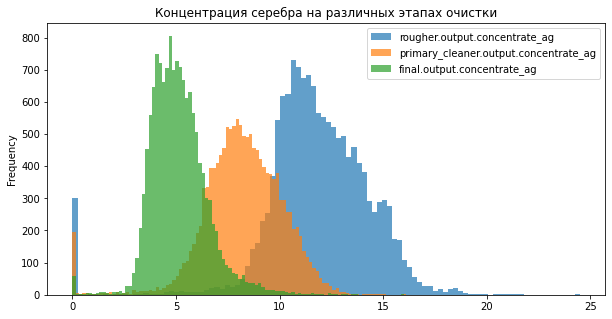

In [ ]:
hist_concentrate('ag','серебра')

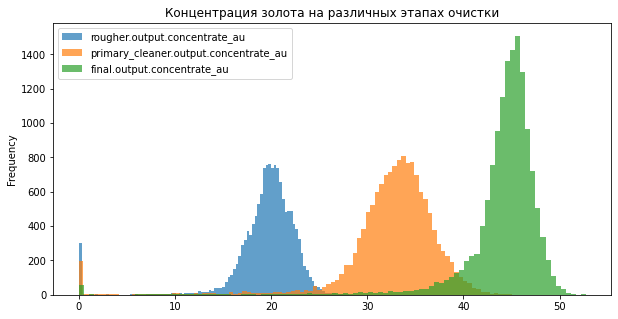

In [ ]:
hist_concentrate('au','золота')

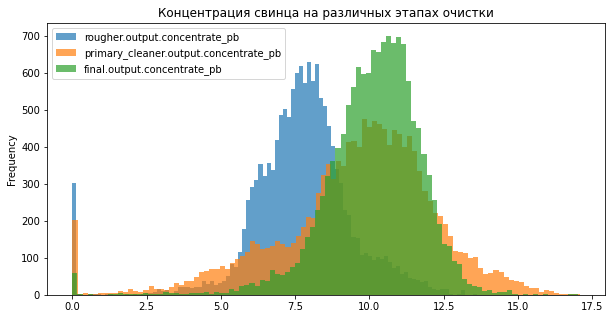

In [ ]:
hist_concentrate('pb','свинца')

Гистограммы отражают следующие распределения по этапам очистки:
*  доля серебра с каждым этапом очистки усеньшается;
*  доля золота с каждым этапом очистки увеличивается, что логично, т.к. цель процесса - получить этот металл на выходе;
*  распределение свинца носит равномерный характер для всех этапов, по всей видимости этот металл используется как вспомогательное вещество.

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

In [ ]:
def hist_feed_size(stage, title, range):
    x0 = df_train[f'{stage}.input.feed_size']
    x1 = df_test[f'{stage}.input.feed_size']

    sns.distplot(x0)
    sns.distplot(x1)
    plt.xlim(range)

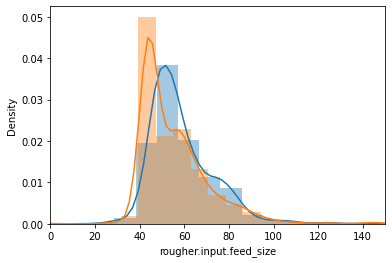

In [ ]:
hist_feed_size('rougher','флотации',(0,150))

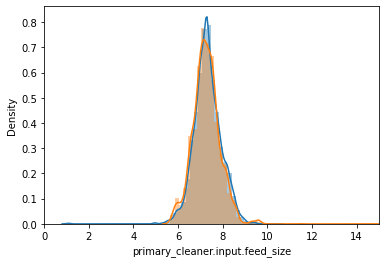

In [ ]:
hist_feed_size('primary_cleaner','первичной очистки',(0,15))

Гистограммы показывают схожий характер распределения размеров гранул на тестовой и обучающей выборках.

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

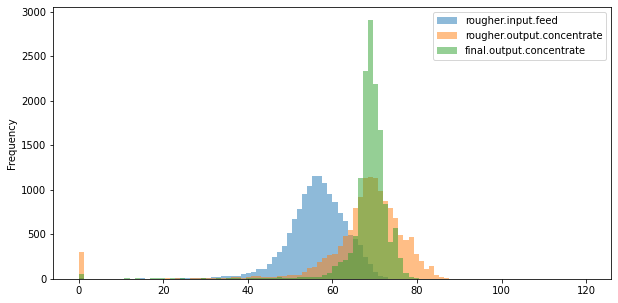

In [ ]:
for stage in ['rougher.input.feed','rougher.output.concentrate','final.output.concentrate']:
    df_train[f'{stage}.total']=(
        df_train[f'{stage}_ag']+
        df_train[f'{stage}_au']+
        df_train[f'{stage}_pb']+
        df_train[f'{stage}_sol']
    )
    df_train[f'{stage}.total'].plot(
        kind='hist',label=stage,legend=True, 
        figsize=(10,5), alpha=.5,range=(0,120), bins=100)


Суммарная концентрация веществ на этапе флотации находится в пределах 50:90; после первичной очистки - 50:75; на финальном этапе - 60:80. Следует обратить внимание на наличие нулевых значений концентрации, по всей видимости процесс в такие моменты прерывался и от таких данных следует избавиться.

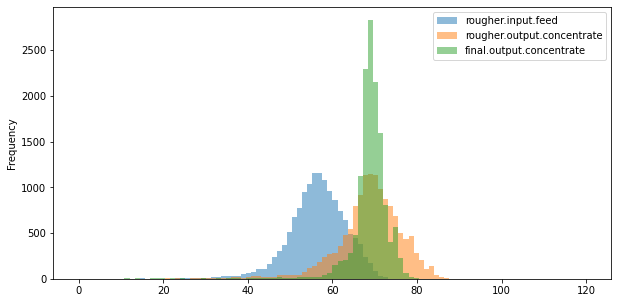

In [ ]:
for stage in ['rougher.input.feed','rougher.output.concentrate','final.output.concentrate']:
    df_train[f'{stage}.total']=(
        df_train[f'{stage}_ag']+
        df_train[f'{stage}_au']+
        df_train[f'{stage}_pb']+
        df_train[f'{stage}_sol']
    )
    df_train = df_train[df_train[f'{stage}.total']>1]
    df_train[f'{stage}.total'].plot(
        kind='hist',label=stage,legend=True, 
        figsize=(10,5), alpha=.5,range=(0,120), bins=100)

## Модель

Напишем функцию для вычисления итоговой sMAPE.

In [ ]:
def smape(target,predict):
    return 100/len(target)*np.sum(2*np.abs(predict-target)/(np.abs(target)+np.abs(predict)))

def final_smape(smape_r, smape_f):
    return 0.25 * smape_r + 0.75 * smape_f

Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке.

Первой рассмотрим линейную регресссию. Для начала обучим модель.

In [ ]:
df_train = df_train.drop(train_only,axis=1) #удаляем из обучающей выборки данные отсутствующие в тестовой выборке, за исключением цлевых признаков
target_train_r = df_train['rougher.output.recovery']
features_train_r = df_train.drop(['rougher.output.recovery','date'] , axis=1)


target_train_f = df_train['final.output.recovery']
features_train_f = df_train.drop(['final.output.recovery','date'] , axis=1)


scaler = StandardScaler() #проведем масштабирование признаков
scaler.fit(features_train_r)
features_train_r = scaler.transform(features_train_r)


scaler.fit(features_train_f)
features_train_f = scaler.transform(features_train_f)




Выбор гиперпараметров для линейной регрессии и обучение моделей. Для поиска оптимального значения использую GridSearchCV с кросс-валидацией на пяти подвыборках

In [ ]:
parameters ={'normalize':[True, False]}
grid_lr_r = RandomizedSearchCV(LinearRegression(),parameters,cv=5, n_jobs=-1,scoring =make_scorer(smape,greater_is_better=False))
grid_lr_r.fit(features_train_r,target_train_r)
grid_lr_r.best_params_

{'normalize': False}

In [ ]:
parameters ={'normalize':[True, False]}
grid_lr_f = RandomizedSearchCV(LinearRegression(),parameters,cv=5, n_jobs=-1,scoring =make_scorer(smape,greater_is_better=False))
grid_lr_f.fit(features_train_f,target_train_f)
grid_lr_f.best_params_

{'normalize': False}

In [ ]:
smape_lr_r = cross_val_score(grid_lr_r.best_estimator_, features_train_r, target_train_r, cv=5,n_jobs=-1, scoring = make_scorer(smape)).mean()
print (f'Значение sMAPE для этапа флотации , модель "Линейная регрессия":{smape_lr_r}')

Значение sMAPE для этапа флотации , модель "Линейная регрессия":5.63241306905657


In [ ]:
smape_lr_f = cross_val_score(grid_lr_f.best_estimator_, features_train_f, target_train_f, cv=5,n_jobs=-1,scoring=make_scorer(smape)).mean()
print (f'Значение sMAPE для финального этапа, модель "Линейная регрессия": {smape_lr_f}')

Значение sMAPE для финального этапа, модель "Линейная регрессия": 8.407755575712702


In [ ]:
print (f'Итоговое значение sMAPE для линейной регрессии: {final_smape(smape_lr_r, smape_lr_f)}')

Итоговое значение sMAPE для линейной регрессии: 7.71391994904867


Решающее дерево и случайный лес.

Для `RandomForestRegressor` поиск будет осуществляться по гиперпараметрам `max_depth` и `n_estimators`. 
Создаю переменную forest_params c различными вариантами значений

In [ ]:
forest_params = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (4,25,2)}

Выбор гиперпараметров для случайного леса и обучение моделей. Для поиска оптимального значения использую GridSearchCV с кросс-валидацией на пяти подвыборках.

In [ ]:
grid_rfr_r = RandomizedSearchCV(RandomForestRegressor(random_state=RANDOM_STATE), forest_params, cv=5, scoring=make_scorer(smape,greater_is_better=False), n_jobs=-1) #запускаем обучение и смотрим какие наилучшие параметры получим при помощи инструмента GridSearchCV
grid_rfr_r.fit(features_train_r, target_train_r)
params = grid_rfr_r.best_params_
rfr_r = RandomForestRegressor(**params, random_state=RANDOM_STATE)
rfr_r.fit(features_train_r, target_train_r)
grid_rfr_r.best_params_

{'n_estimators': 50, 'max_depth': 24}

In [ ]:
grid_rfr_f = RandomizedSearchCV(RandomForestRegressor(random_state=RANDOM_STATE), forest_params, cv=5, scoring=make_scorer(smape,greater_is_better=False), n_jobs=-1) #запускаем обучение и смотрим какие наилучшие параметры получим при помощи инструмента GridSearchCV
grid_rfr_f.fit(features_train_f, target_train_f)
params = grid_rfr_f.best_params_
rfr_f = RandomForestRegressor(**params, random_state=RANDOM_STATE)
rfr_f.fit(features_train_f, target_train_f)
grid_rfr_f.best_params_

{'n_estimators': 20, 'max_depth': 4}

In [ ]:
smape_rfr_r = cross_val_score(rfr_r, features_train_r, target_train_r, cv=5,n_jobs=-1, scoring = make_scorer(smape)).mean()
print (f'Значение sMAPE для этапа флотации , модель "Случайный лес": {smape_rfr_r}')

Значение sMAPE для этапа флотации , модель "Случайный лес": 5.342354326005852


In [ ]:
smape_rfr_f = cross_val_score(rfr_f, features_train_f, target_train_f, cv=5,n_jobs=-1, scoring = make_scorer(smape)).mean()
print (f'Значение sMAPE для финального этапа , модель "Случайный лес": {smape_rfr_f}')

Значение sMAPE для финального этапа , модель "Случайный лес": 7.82189888067457


In [ ]:
print (f'Итоговое значение sMAPE для случайного леса: {final_smape(smape_rfr_r, smape_rfr_f)}')

Итоговое значение sMAPE для случайного леса: 7.2020127420073905


Выбор гиперпараметров для решающего дерева и обучение моделей. Для поиска оптимального значения использую GridSearchCV с кросс-валидацией на пяти подвыборках.

In [ ]:
tree_params = {'max_depth': range (4,20,2)}

In [ ]:
grid_dtr_r = RandomizedSearchCV(DecisionTreeRegressor(random_state=RANDOM_STATE), tree_params, cv=5, scoring = make_scorer(smape,greater_is_better=False), n_jobs=-1) #запускаем обучение и смотрим какие наилучшие параметры получим при помощи инструмента GridSearchCV
grid_dtr_r.fit(features_train_r, target_train_r)
params = grid_dtr_r.best_params_
dtr_r = DecisionTreeRegressor(**params, random_state=RANDOM_STATE)
dtr_r.fit(features_train_r, target_train_r)
grid_dtr_r.best_params_

{'max_depth': 6}

In [ ]:
grid_dtr_f = RandomizedSearchCV(DecisionTreeRegressor(random_state=RANDOM_STATE), tree_params, cv=5, scoring = make_scorer(smape,greater_is_better=False), n_jobs=-1) #запускаем обучение и смотрим какие наилучшие параметры получим при помощи инструмента GridSearchCV
grid_dtr_f.fit(features_train_f, target_train_f)
params = grid_dtr_f.best_params_
dtr_f = DecisionTreeRegressor(**params, random_state=RANDOM_STATE)
dtr_f.fit(features_train_r, target_train_r)
grid_dtr_f.best_params_

{'max_depth': 4}

In [ ]:
smape_dtr_r = cross_val_score(dtr_r, features_train_r, target_train_r, cv=5,n_jobs=-1, scoring = make_scorer(smape)).mean()
print (f'Значение sMAPE для этапа флотации , модель "Решающее дерево":{smape_dtr_r}')

Значение sMAPE для этапа флотации , модель "Решающее дерево":6.644265425164582


In [ ]:
smape_dtr_f = cross_val_score(dtr_f, features_train_f, target_train_f, cv=5,n_jobs=-1, scoring = make_scorer(smape)).mean()
print (f'Значение sMAPE для эфинального этапа , модель "Решающее дерево": {smape_dtr_f}')

Значение sMAPE для эфинального этапа , модель "Решающее дерево": 8.241422053076139


In [ ]:
print (f'Итоговое значение sMAPE для решающего дерева:{final_smape(smape_dtr_r, smape_dtr_f)}')

Итоговое значение sMAPE для решающего дерева:7.842132896098249


На основании сравнения показателей итоговых sMAPE для трех моделей, в качестве лучшей модели выбираем случайный лес.

Перейдем к проверке лучшей выбранной модели на тестовой выборке. Для этого объединим полную и тестовую выборку и выделим в полученном датасете признаки, использованные для обучения моделей.

In [ ]:
df = df_full.merge(df_test,on='date').reset_index()
df

train_in_df = []
for col in df_train.columns:
    if col in df.columns:
        train_in_df.append(col)
train_in_df

['date', 'final.output.recovery', 'rougher.output.recovery']

In [ ]:
train_in_full = []
for col in df_train.columns:
    if col in df_full.columns:
        train_in_full.append(col)
train_in_full

['date',
 'final.output.recovery',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.output.recovery',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.fl

Разделим выборку на расчетные и целевые признаки, предварительно выбрав признаки, использованные для обучения модели.

In [ ]:
df = df[train_in_df]
target_test_r = df['rougher.output.recovery']
features_test_r = df.drop(['rougher.output.recovery','date'],axis=1)

target_test_f = df['final.output.recovery']
features_test_f = df.drop(['final.output.recovery','date'],axis=1)
scaler = StandardScaler() #проведем масштабирование признаков
scaler.fit(features_test_r)
features_test_r = scaler.transform(features_test_r)
scaler.fit(features_test_f)
features_test_f = scaler.transform(features_test_f)


In [ ]:
smape_rfr_r_test = cross_val_score(rfr_r, features_test_r, target_test_r, cv=5,n_jobs=-1, scoring = make_scorer(smape)).mean()
print (f'sMAPE на этапе флотации для тестовой выборки: {smape_rfr_r_test}')

sMAPE на этапе флотации для тестовой выборки: 10.142707287073648


In [ ]:
smape_rfr_f_test = cross_val_score(rfr_f, features_test_f, target_test_f, cv=5,n_jobs=-1, scoring = make_scorer(smape)).mean()
print (f'sMAPE на финальном этапе для тестовой выборки:{smape_rfr_f_test}')

sMAPE на финальном этапе для тестовой выборки:8.193931551176687


In [ ]:
print (f'Итоговый sMAPE  для тестовой выборки: {final_smape(smape_rfr_r_test, smape_rfr_f_test)}')

Итоговый sMAPE  для тестовой выборки: 8.681125485150927


Сравним результаты sMAPE лучшей модели со sMAPE на константной модели. ДЛя определения константной модели будем использовать DummyRegressor с медианной стратегией.

In [ ]:
dummy_regr_r = DummyRegressor(strategy="median")
dummy_r = dummy_regr_r.fit(features_train_r,target_train_r)
pred_r = dummy_regr_r.predict(features_test_r)

dummy_regr_f = DummyRegressor(strategy="median")
dummy_f = dummy_regr_f.fit(features_train_f,target_train_f)
pred_f = dummy_regr_f.predict(features_test_f)

smape_dummy_r = cross_val_score(dummy_r, features_test_r, target_test_r, cv=5,n_jobs=-1, scoring = make_scorer(smape)).mean()
smape_dummy_r

smape_dummy_f = cross_val_score(dummy_f, features_test_f, target_test_f, cv=5,n_jobs=-1, scoring = make_scorer(smape)).mean()
smape_dummy_f

final_smape(smape_dummy_r, smape_dummy_f)

9.151913059672934

# Общий вывод

В ходе работы над проектом мы провели исследование трех выборок с данными и провели их предобработку.

Проверили и подтвердили правильность расчета эффективности обогащения для этапа флотации.

В ходе анализа данных было изучено распределение концентрации веществ в зависимости от этапа проведения восстановления золота из руды.

Были сделаны следующие выводы:
*  доля серебра с каждым этапом очистки уменьшается;
*  доля золота с каждым этапом очистки увеличивается, что логично, т.к. цель процесса - получить этот металл на выходе;
*  распределение свинца носит равномерный характер для всех этапов, по всей видимости этот металл используется как вспомогательное вещество при разделении фракций.

Изучение распределения размеров гранул показало, что оно носит равномерный характер для этапов флотации и финального этапа.

На этапе анализа суммарной концентрации веществ по этапам очистки золота, была выявлена аномалия: большое количество нулевых значений, что может свидельствовать о прерывании процесса очистки, признаки с такими значениями было решено исключить из выборки.

Были подобраны параметры и построены 3 модели:
* линейная регрессия;
* случайный лес;
* дерево решений.

На основании расчета sMAPE для каждой модели была выбрана наилучшая с минимальным значением данного показателя - линейная регрессия.

Лучшая модель была проверена на тестовой выборке, её качество было подтверждено сравнением со sMAPE константной модели.
Качество лучшей модели оуказалось выше, что дает нам полное право рекомендовать данную модель для использования в предсказаниях коэффициента восстановления золота из золотосодержащей руды.

